---
title: Choice of Closed Transform
subtitle: Fitting shapes using Different Closed Transforms
date: 2025-03-09
---

In [1]:
# Basic imports
import torch
from torch import nn
import geosimilarity as gs
from NIGnets import NIGnet
from NIGnets.monotonic_nets import SmoothMinMaxNet

from assets.utils import automate_training, plot_surfaces

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Choice of Closed Transform
The closed transform from the unit square to the unit sphere as we did earlier leads to
concentration of points on the poles of the sphere. This is shown below:

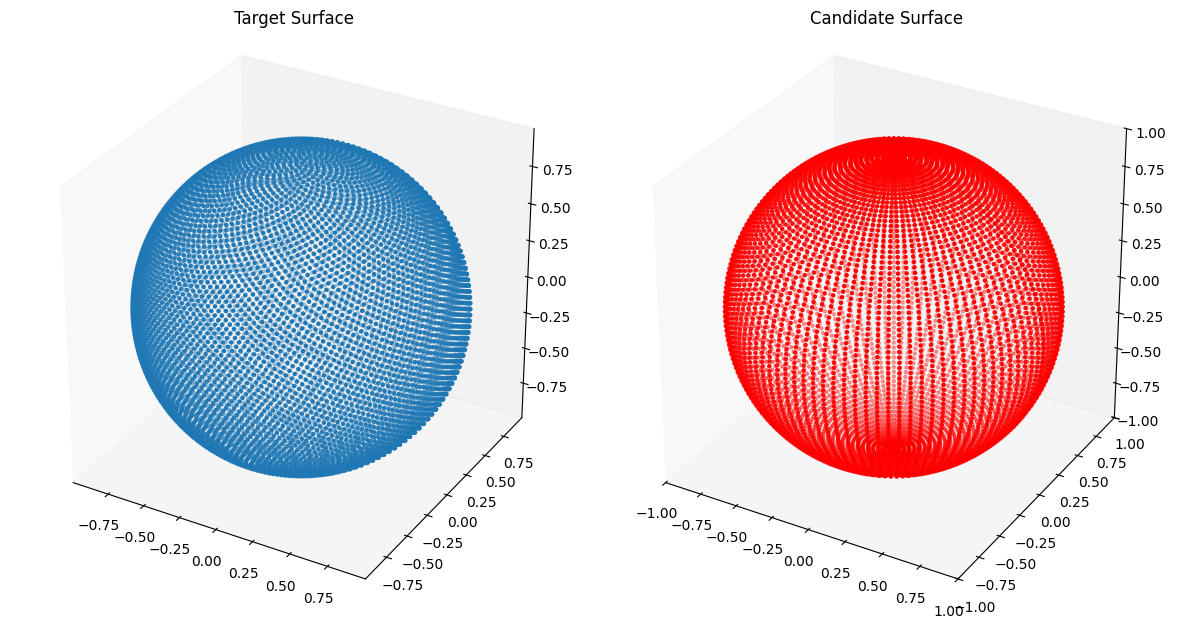

In [2]:
from assets.shapes import sphere

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = sphere(num_pts * num_pts).to(device)

closed_transform = lambda t, s: torch.hstack([
    torch.sin(torch.pi * s) * torch.cos(2 * torch.pi * t),
    torch.sin(torch.pi * s) * torch.sin(2 * torch.pi * t),
    torch.cos(torch.pi * s)
])

Xc = closed_transform(T[:, 0:1], T[:, 1:2])

# Plot the candidate and the target geometries
plot_surfaces(Xc, Xt)

## Fitting Curves with Uniformly Spaced Closed Transform
Now for our closed transform we use the same method we use earlier to generate points on the target
sphere which has uniformly spaced points on the surface.

In [2]:
def uniformly_spaced_closed_transform(num_pts: int) -> torch.Tensor:
    """Generates approximately evenly distributed points on the unit sphere using the Fibonacci
    lattice.
    """
    idx = torch.arange(0, num_pts) + 0.5
    phi = torch.arccos(1 - 2 * idx / num_pts)
    theta = torch.pi * (1 + 5**0.5) * idx

    # Compute x, y and z coordinates
    x = torch.sin(phi) * torch.cos(theta)
    y = torch.sin(phi) * torch.sin(theta)
    z = torch.cos(phi)

    # Concatenate to form a matrix of shape: (num_pts, 3)
    X = torch.stack([x, y, z], dim = 1)
    return X

class PreAuxNet_uniform_closed(nn.Module):
    def __init__(self, layer_count, hidden_dim):
        super().__init__()

        # Pre-Auxilliary net needs closed transform to get same r at theta = 0, 2pi
        self.closed_transform = uniformly_spaced_closed_transform

        layers = [nn.Linear(3, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.PReLU()]
        for i in range(layer_count):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.PReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.ReLU())

        self.forward_stack = nn.Sequential(*layers)
    
    def forward(self, t, s):
        unit_sphere = self.closed_transform(t.shape[0]).to('mps')

        r = self.forward_stack(unit_sphere)
        X = r * unit_sphere
        return X

Epoch: [   1/1000]. Loss:    1.672467
Epoch: [ 200/1000]. Loss:    0.003895
Epoch: [ 400/1000]. Loss:    0.002689
Epoch: [ 600/1000]. Loss:    0.001234
Epoch: [ 800/1000]. Loss:    0.000960
Epoch: [1000/1000]. Loss:    0.000811


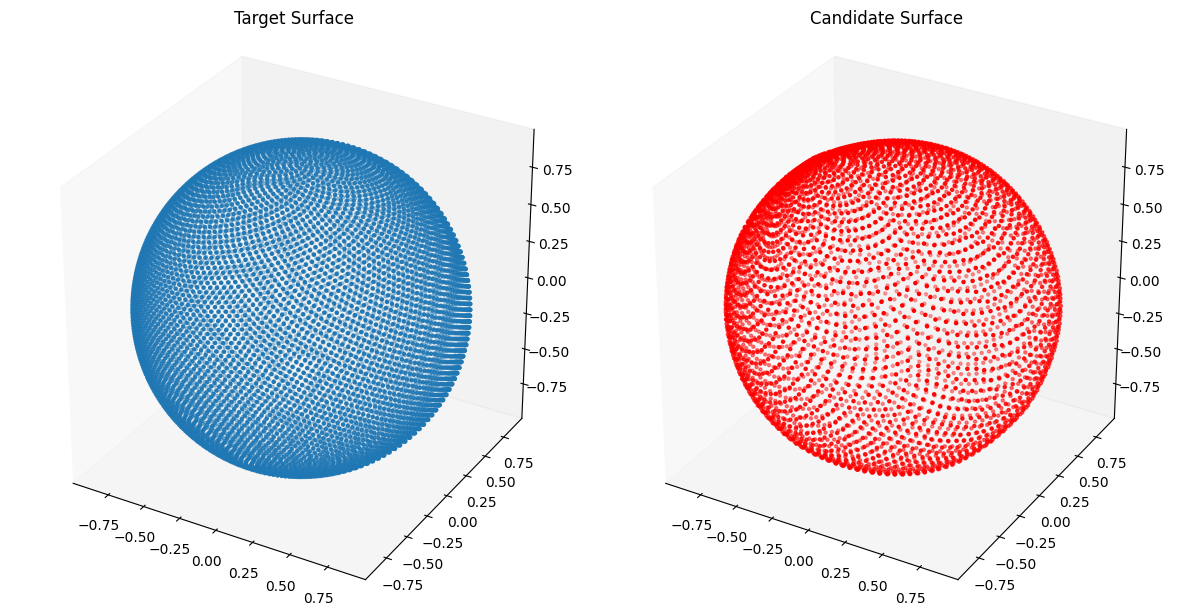

In [6]:
from assets.shapes import sphere

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = sphere(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet_uniform_closed(layer_count = 2, hidden_dim = 15)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 3, nodes_per_group = 3)
nig_net = NIGnet(layer_count = 3, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3, skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

In [7]:
from assets.shapes import cube

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = cube(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet_uniform_closed(layer_count = 2, hidden_dim = 15)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 3, nodes_per_group = 3)
nig_net = NIGnet(layer_count = 3, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3, skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

Epoch: [   1/1000]. Loss:    2.388507
Epoch: [ 200/1000]. Loss:    0.003198
Epoch: [ 400/1000]. Loss:    0.002269
Epoch: [ 600/1000]. Loss:    0.001963
Epoch: [ 800/1000]. Loss:    0.001566
Epoch: [1000/1000]. Loss:    0.001408


Epoch: [   1/1000]. Loss:    0.738155
Epoch: [ 200/1000]. Loss:    0.076094
Epoch: [ 400/1000]. Loss:    0.006795
Epoch: [ 600/1000]. Loss:    0.004894
Epoch: [ 800/1000]. Loss:    0.004846
Epoch: [1000/1000]. Loss:    0.003950


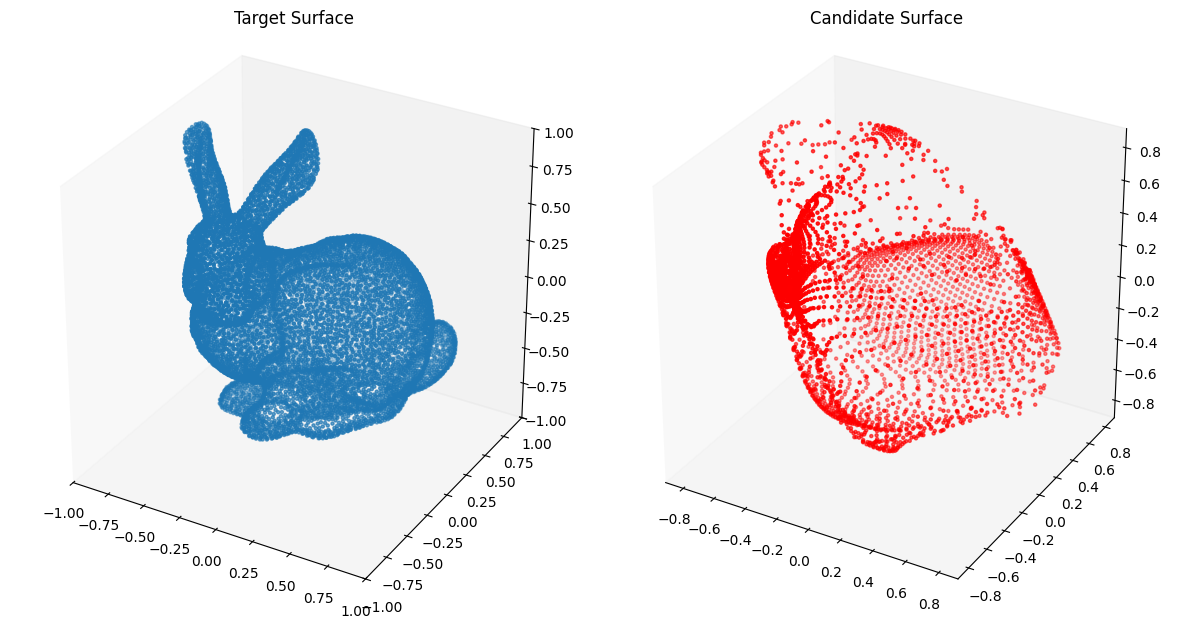

In [4]:
from assets.shapes import stanford_bunny_3d

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = stanford_bunny_3d(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet_uniform_closed(layer_count = 5, hidden_dim = 100)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 15, nodes_per_group = 15)
nig_net = NIGnet(layer_count = 5, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

## Fitting Curves with Randomly Sampled Closed Transform
We instead of using the same points on the unit sphere we sample points randomly on it.

In [6]:
from assets.shapes import sphere

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = sphere(num_pts * num_pts).to(device)

def randomly_sampled_closed_transform(num_pts: int) -> torch.Tensor:
    X = torch.randn(num_pts, 3)
    X = X / torch.linalg.norm(X, axis = 1, keepdim = True)
    return X

Xc = randomly_sampled_closed_transform(T.shape[0])

# Plot the candidate and the target geometries
plot_surfaces(Xc, Xt)

In [9]:
def randomly_sampled_closed_transform(num_pts: int) -> torch.Tensor:
    X = torch.randn(num_pts, 3)
    X = X / torch.linalg.norm(X, axis = 1, keepdim = True)
    return X


class PreAuxNet_random_closed(nn.Module):
    def __init__(self, layer_count, hidden_dim):
        super().__init__()

        # Pre-Auxilliary net needs closed transform to get same r at theta = 0, 2pi
        self.closed_transform = randomly_sampled_closed_transform

        layers = [nn.Linear(3, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.PReLU()]
        for i in range(layer_count):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.PReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.ReLU())

        self.forward_stack = nn.Sequential(*layers)
    
    def forward(self, t, s):
        unit_sphere = self.closed_transform(t.shape[0]).to('mps')

        r = self.forward_stack(unit_sphere)
        X = r * unit_sphere
        return X

Epoch: [   1/1000]. Loss:    1.497367
Epoch: [ 200/1000]. Loss:    0.003155
Epoch: [ 400/1000]. Loss:    0.001660
Epoch: [ 600/1000]. Loss:    0.001610
Epoch: [ 800/1000]. Loss:    0.002126
Epoch: [1000/1000]. Loss:    0.001554


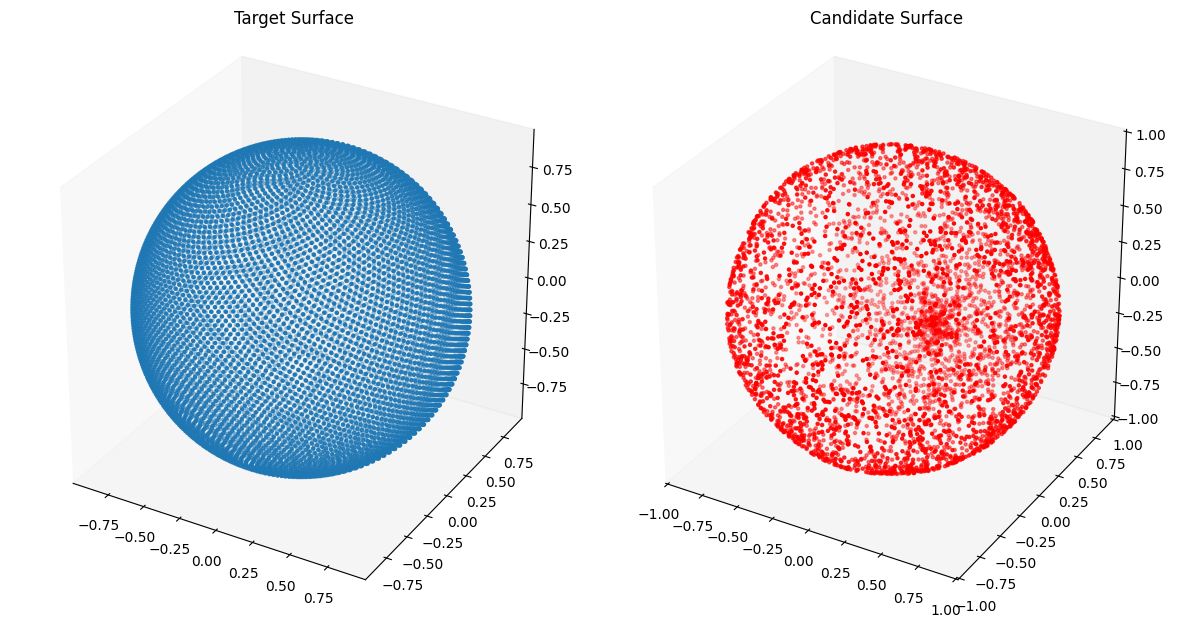

In [12]:
from assets.shapes import sphere

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = sphere(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet_random_closed(layer_count = 2, hidden_dim = 15)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 3, nodes_per_group = 3)
nig_net = NIGnet(layer_count = 3, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3, skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

Epoch: [   1/1000]. Loss:    2.264105
Epoch: [ 200/1000]. Loss:    0.026597
Epoch: [ 400/1000]. Loss:    0.007183
Epoch: [ 600/1000]. Loss:    0.004772
Epoch: [ 800/1000]. Loss:    0.003386
Epoch: [1000/1000]. Loss:    0.003301


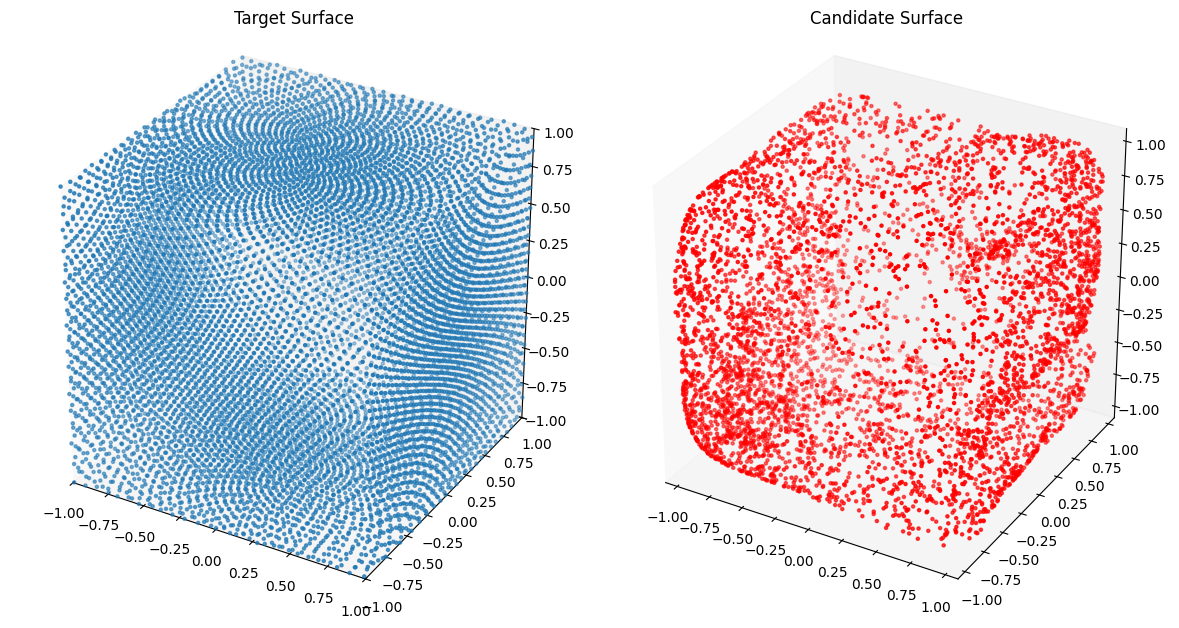

In [13]:
from assets.shapes import cube

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = cube(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet_random_closed(layer_count = 2, hidden_dim = 15)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 3, nodes_per_group = 3)
nig_net = NIGnet(layer_count = 3, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3, skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.01, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

Epoch: [   1/1000]. Loss:    0.743143
Epoch: [ 200/1000]. Loss:    0.086414
Epoch: [ 400/1000]. Loss:    0.086343
Epoch: [ 600/1000]. Loss:    0.084482
Epoch: [ 800/1000]. Loss:    0.007319
Epoch: [1000/1000]. Loss:    0.004829


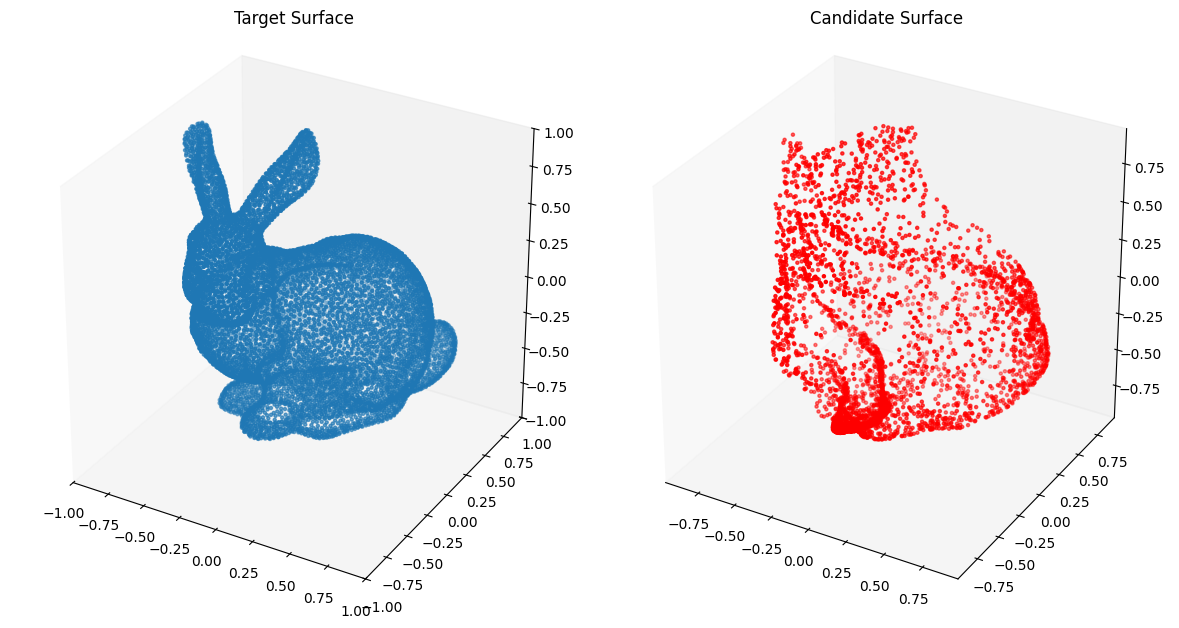

In [9]:
from assets.shapes import stanford_bunny_3d

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = stanford_bunny_3d(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
preaux_net = PreAuxNet_random_closed(layer_count = 5, hidden_dim = 100)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 15, nodes_per_group = 15)
nig_net = NIGnet(layer_count = 5, preaux_net = preaux_net, monotonic_net = monotonic_net,
                 geometry_dim = 3).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)